In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


In [2]:
train_batch_size = 100
test_batch_size = 64

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# function fot generating random targets
def randomize_target(target):
    return torch.randint(0, 10, ()).item()

In [3]:
# Using a lambda transform to modify targets in the loader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset.targets = list(map(lambda x: randomize_target(x), trainset.targets))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=False)

Files already downloaded and verified


In [4]:
# testing without target modification
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified


In [5]:
class CNN_Model1(nn.Module):
    def __init__(self):
        super(CNN_Model1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.bn1(self.conv1(x)), 2), negative_slope=0.01)
        x = F.leaky_relu(F.max_pool2d(self.bn2(self.conv2(x)), 2), negative_slope=0.01)
        x = F.leaky_relu(F.max_pool2d(self.bn3(self.conv3(x)), 2), negative_slope=0.01)
        x = x.view(-1, 64 * 4 * 4)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
class CNN_Model2(nn.Module):
    def __init__(self):
        super(CNN_Model2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2), negative_slope=0.01)
        x = self.bn1(x)
        x = F.leaky_relu(F.max_pool2d(self.conv2(x), 2), negative_slope=0.01)
        x = self.bn2(x)
        x = F.leaky_relu(F.max_pool2d(self.conv3(x), 2), negative_slope=0.01)
        x = self.bn3(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
class CNN_Model3(nn.Module):
    def __init__(self):
        super(CNN_Model3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256, 512)  
        self.fc2 = nn.Linear(512, 10)   

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.01))
        x = F.avg_pool2d(x, x.size()[2:])  
        x = x.view(x.size(0), -1)  
        x = self.dropout1(x)
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
# Train model for one epoch
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    return total_train_loss / len(train_loader)

In [9]:
# Evaluate model on the test set
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_test_loss = 0.0
    total_correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            total_test_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1, keepdim=True)
            total_correct += preds.eq(labels.view_as(preds)).sum().item()

    return total_test_loss / len(test_loader), total_correct / len(test_loader.dataset)

In [10]:
# Log the results for each epoch
def log_epoch(epoch, train_loss, test_loss, accuracy):
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

In [11]:
# Main function to train and evaluate the model over multiple epochs
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, epochs):
    train_losses, test_losses, accuracies = [], [], []
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        test_loss, accuracy = evaluate_model(model, test_loader, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracies.append(accuracy)
        log_epoch(epoch, train_loss, test_loss, accuracy)
    return train_losses, test_losses, accuracies

In [12]:
# Define a reusable function to train and evaluate different models
def train_model(model, train_loader, test_loader, loss_func, epochs, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return train_and_evaluate_model(model, train_loader, test_loader, optimizer, loss_func, epochs)

In [13]:
# Initialize the loss function
loss_func = nn.CrossEntropyLoss()

In [14]:
# Training Model 1
print("Training Model 1:")
model1 = CNN_Model1()
train_losses_1, test_losses_1, accuracies_1 = train_model(model1, trainloader, testloader, loss_func, epochs=15)

Training Model 1:
Epoch 1, Train Loss: 2.3054, Test Loss: 2.3007, Accuracy: 0.0948
Epoch 2, Train Loss: 2.3032, Test Loss: 2.3017, Accuracy: 0.1068
Epoch 3, Train Loss: 2.3031, Test Loss: 2.3010, Accuracy: 0.1043
Epoch 4, Train Loss: 2.3031, Test Loss: 2.3039, Accuracy: 0.1021
Epoch 5, Train Loss: 2.3030, Test Loss: 2.3019, Accuracy: 0.1096
Epoch 6, Train Loss: 2.3027, Test Loss: 2.3035, Accuracy: 0.0894
Epoch 7, Train Loss: 2.3027, Test Loss: 2.3012, Accuracy: 0.1310
Epoch 8, Train Loss: 2.3030, Test Loss: 2.3009, Accuracy: 0.1073
Epoch 9, Train Loss: 2.3021, Test Loss: 2.3015, Accuracy: 0.1178
Epoch 10, Train Loss: 2.3019, Test Loss: 2.3022, Accuracy: 0.1023
Epoch 11, Train Loss: 2.3012, Test Loss: 2.3063, Accuracy: 0.0875
Epoch 12, Train Loss: 2.3004, Test Loss: 2.3115, Accuracy: 0.1041
Epoch 13, Train Loss: 2.2981, Test Loss: 2.3094, Accuracy: 0.0995
Epoch 14, Train Loss: 2.2914, Test Loss: 2.3247, Accuracy: 0.0852
Epoch 15, Train Loss: 2.2805, Test Loss: 2.3407, Accuracy: 0.0905


In [15]:
# Training Model 2
print("\nTraining Model 2:")
model2 = CNN_Model2()
train_losses_2, test_losses_2, accuracies_2 = train_model(model2, trainloader, testloader, loss_func, epochs=15)


Training Model 2:
Epoch 1, Train Loss: 2.3213, Test Loss: 2.3235, Accuracy: 0.0658
Epoch 2, Train Loss: 2.3031, Test Loss: 2.3083, Accuracy: 0.0838
Epoch 3, Train Loss: 2.3007, Test Loss: 2.3078, Accuracy: 0.1156
Epoch 4, Train Loss: 2.2896, Test Loss: 2.3100, Accuracy: 0.1051
Epoch 5, Train Loss: 2.2634, Test Loss: 2.3341, Accuracy: 0.1177
Epoch 6, Train Loss: 2.2020, Test Loss: 2.3950, Accuracy: 0.1066
Epoch 7, Train Loss: 2.0875, Test Loss: 2.5796, Accuracy: 0.1052
Epoch 8, Train Loss: 1.9378, Test Loss: 2.8587, Accuracy: 0.1061
Epoch 9, Train Loss: 1.7698, Test Loss: 3.1145, Accuracy: 0.1058
Epoch 10, Train Loss: 1.6231, Test Loss: 3.4030, Accuracy: 0.1015
Epoch 11, Train Loss: 1.5049, Test Loss: 3.7017, Accuracy: 0.1000
Epoch 12, Train Loss: 1.3780, Test Loss: 4.0807, Accuracy: 0.1005
Epoch 13, Train Loss: 1.2505, Test Loss: 4.4345, Accuracy: 0.1008
Epoch 14, Train Loss: 1.1228, Test Loss: 4.8624, Accuracy: 0.1005
Epoch 15, Train Loss: 1.0090, Test Loss: 5.2000, Accuracy: 0.1000


In [16]:
# Training Model 3
print("\nTraining Model 3:")
model3 = CNN_Model3()
train_losses_3, test_losses_3, accuracies_3 = train_model(model3, trainloader, testloader, loss_func, epochs=15)


Training Model 3:
Epoch 1, Train Loss: 2.3107, Test Loss: 2.3049, Accuracy: 0.0732
Epoch 2, Train Loss: 2.3037, Test Loss: 2.3023, Accuracy: 0.0734
Epoch 3, Train Loss: 2.3033, Test Loss: 2.3025, Accuracy: 0.0805
Epoch 4, Train Loss: 2.3034, Test Loss: 2.3074, Accuracy: 0.0725
Epoch 5, Train Loss: 2.3032, Test Loss: 2.3073, Accuracy: 0.1136
Epoch 6, Train Loss: 2.3030, Test Loss: 2.3032, Accuracy: 0.0746
Epoch 7, Train Loss: 2.3035, Test Loss: 2.3030, Accuracy: 0.0974
Epoch 8, Train Loss: 2.3032, Test Loss: 2.3061, Accuracy: 0.0669
Epoch 9, Train Loss: 2.3033, Test Loss: 2.3028, Accuracy: 0.0932
Epoch 10, Train Loss: 2.3030, Test Loss: 2.3031, Accuracy: 0.0994
Epoch 11, Train Loss: 2.3031, Test Loss: 2.3034, Accuracy: 0.1088
Epoch 12, Train Loss: 2.3032, Test Loss: 2.3025, Accuracy: 0.0874
Epoch 13, Train Loss: 2.3031, Test Loss: 2.3030, Accuracy: 0.0846
Epoch 14, Train Loss: 2.3028, Test Loss: 2.3013, Accuracy: 0.0855
Epoch 15, Train Loss: 2.3030, Test Loss: 2.3028, Accuracy: 0.0798


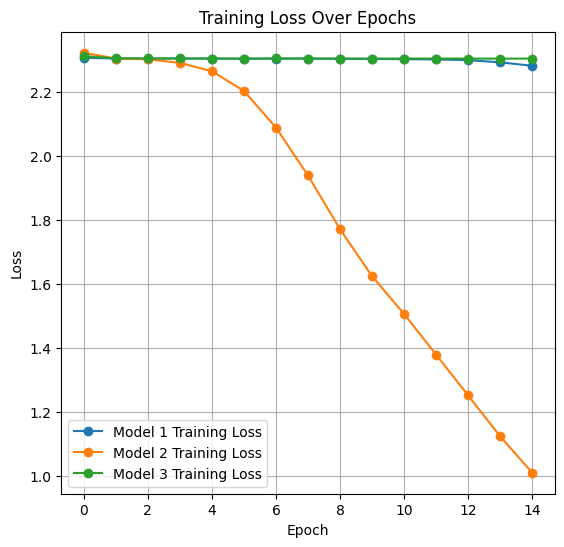

In [17]:
# Creating a figure 
plt.figure(figsize=(14, 6))

# Plot training loss for all models
plt.subplot(1, 2, 1)
plt.plot(train_losses_1, label='Model 1 Training Loss', marker='o')
plt.plot(train_losses_2, label='Model 2 Training Loss', marker='o')
plt.plot(train_losses_3, label='Model 3 Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

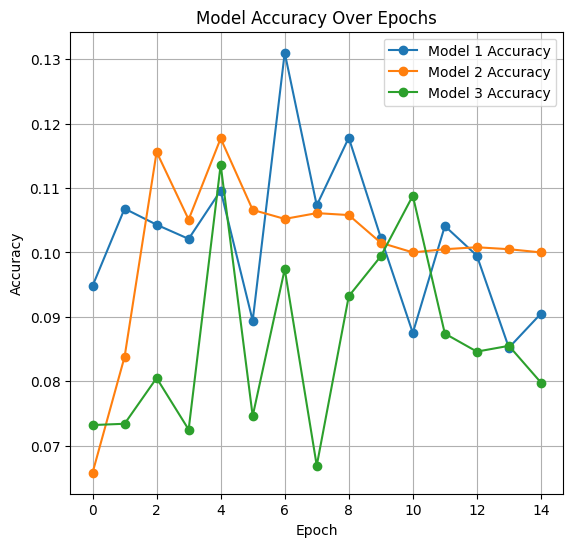

In [18]:
# Plot accuracy for all models
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
plt.plot(accuracies_1, label='Model 1 Accuracy', marker='o')
plt.plot(accuracies_2, label='Model 2 Accuracy', marker='o')
plt.plot(accuracies_3, label='Model 3 Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.grid(True)
plt.legend()

In [19]:
# Show the plots
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>